In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters: {'nb__alpha': 0.1, 'features__tfidf__ngram_range': (1, 1), 'features__tfidf__min_df': 2, 'features__tfidf__max_df': 0.75, 'features__count__ngram_range': (1, 2), 'features__count__min_df': 2, 'features__count__max_df': 0.5}
Best Score: 0.7294623161764706
Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.71       128
           1       0.76      0.79      0.78       156

    accuracy                           0.75       284
   macro avg       0.75      0.75      0.75       284
weighted avg       0.75      0.75      0.75       284



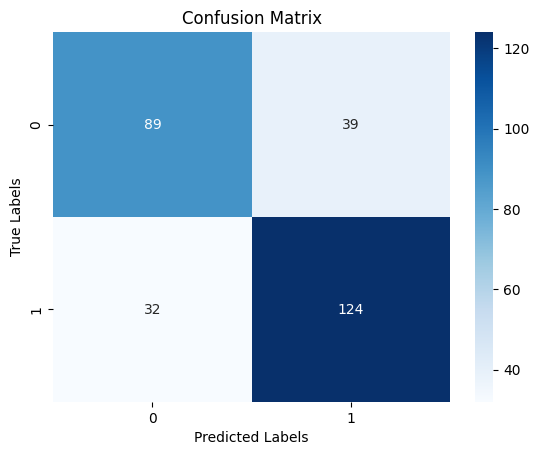

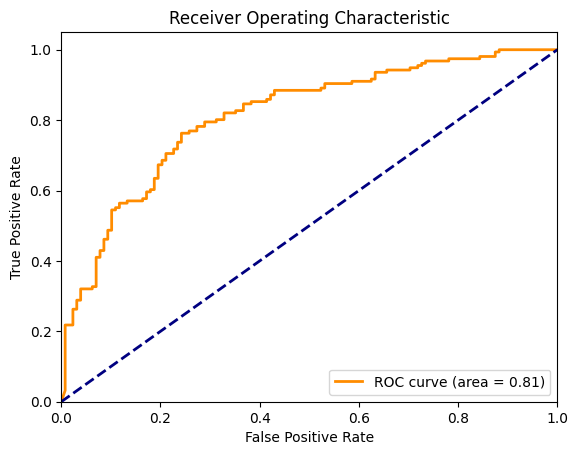

In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import download
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Download NLTK resources
download('punkt')
download('stopwords')
download('wordnet')


# More complex text preprocessing function
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'\W+', ' ', text)
    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text.lower())
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(lemmatized_words)


# Text length extractor
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([len(text) for text in X]).reshape(-1, 1)


# Load data
file_path = '/content/gdrive/MyDrive/PHD/CS 6830/Project5/Human Stress Prediction/Stress.csv'
data = pd.read_csv(file_path)

# Apply preprocessing to the text in the dataset
data['text'] = data['text'].apply(preprocess_text)

# Create pipeline for feature extraction and classification
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer()),
        ('count', CountVectorizer()),
        ('length', TextLengthExtractor())
    ])),
    ('nb', MultinomialNB())
])

# Define parameter space for random search
param_distributions = {
    'features__tfidf__max_df': [0.5, 0.75],
    'features__tfidf__min_df': [1, 2],
    'features__tfidf__ngram_range': [(1, 1), (1, 2)],
    'features__count__max_df': [0.5, 0.75],
    'features__count__min_df': [1, 2],
    'features__count__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.001, 0.01, 0.1]
}

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.1, random_state=42)

# Set up random search
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=50, cv=10, n_jobs=-1, verbose=1)

# Perform random search to find the best parameters
random_search.fit(X_train, y_train)

# Print best parameters and scores
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Use the best parameters for prediction
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print model evaluation results
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC
if len(np.unique(y_test)) == 2:
    y_prob = random_search.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
